In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Model Architecture: UniScriptNet
# ----------------------------

def build_uniscriptnet(input_shape=(32, 32, 1), num_classes = 28):
    model = Sequential([
        InputLayer(input_shape=input_shape),
        
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fully Connected
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

print("Model Designed successfully")

2025-06-09 15:34:10.497164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749483251.009928      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749483251.136303      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model Designed successfully


In [3]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 2. Load CSV Data
# ----------------------------
train_images = pd.read_csv("/kaggle/input/ahcd-2/Arabic Handwritten Characters Dataset CSV/csvTrainImages 13440x1024.csv", header=None).values
train_labels = pd.read_csv("/kaggle/input/ahcd-2/Arabic Handwritten Characters Dataset CSV/csvTrainLabel 13440x1.csv", header=None).values.flatten()

test_images = pd.read_csv("/kaggle/input/ahcd-2/Arabic Handwritten Characters Dataset CSV/csvTestImages 3360x1024.csv", header=None).values
test_labels = pd.read_csv("/kaggle/input/ahcd-2/Arabic Handwritten Characters Dataset CSV/csvTestLabel 3360x1.csv", header=None).values.flatten()

# ----------------------------
# 3. Reshape to 32x32 and Normalize
# ----------------------------
train_images = train_images.reshape(-1, 32, 32).astype("uint8")
test_images = test_images.reshape(-1, 32, 32).astype("uint8")

# ----------------------------
# 4. Save Images in Folders
# ----------------------------
def save_images(images, labels, base_dir):
    for i in range(len(images)):
        label = str(labels[i])
        label_dir = os.path.join(base_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        img = Image.fromarray(images[i])
        img.save(os.path.join(label_dir, f"{i}.png"))

save_images(train_images, train_labels, "ahcd/train")
save_images(test_images, test_labels, "ahcd/val")


In [5]:
# ----------------------------
# 5. ImageDataGenerator Setup
# ----------------------------
image_size = (32, 32)
input_shape = (32, 32, 1)
batch_size = 64
num_classes = 28
epochs = 80

# ImageDataGenerator with augmentation for training and only rescaling for validation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,              # Safe for all
    width_shift_range=0.05,         
    height_shift_range=0.05,
    zoom_range=0.1,
    shear_range=0.05,
    horizontal_flip=False,          # Do not flip
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    "ahcd/train",
    target_size=image_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=33
)

val_generator = datagen.flow_from_directory(
    "ahcd/val",
    target_size=image_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    seed=33
)

Found 13440 images belonging to 28 classes.
Found 3360 images belonging to 28 classes.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer


# ----------------------------
# 6. Compile Model
# ----------------------------
model = build_uniscriptnet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1749483554.279746      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749483554.280389      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 28)                  │           7,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 626,332 (2.39 MB)

 Trainable params: 625,372 (2.39 MB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
# ----------------------------
# 7. Callbacks
# ----------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("uniscriptnet_AHCD_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

epochs = 80

# ----------------------------
# 8. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749483585.996283     115 service.cc:148] XLA service 0x7f220c009180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749483585.997946     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749483585.997975     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749483586.626294     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/210 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.0395 - loss: 4.7386 

I0000 00:00:1749483593.387864     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2391 - loss: 2.9768
Epoch 1: val_accuracy improved from -inf to 0.03571, saving model to uniscriptnet_AHCD_best.h5
210/210 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.2403 - loss: 2.9698 - val_accuracy: 0.0357 - val_loss: 6.5263 - learning_rate: 0.0010
Epoch 2/80
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6099 - loss: 1.1783
Epoch 2: val_accuracy improved from 0.03571 to 0.18363, saving model to uniscriptnet_AHCD_best.h5
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.6103 - loss: 1.1772 - val_accuracy: 0.1836 - val_loss: 2.8820 - learning_rate: 0.0010
Epoch 3/80
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7476 - loss: 0.7662
Epoch 3: val_accuracy improved from 0.18363 to 0.71577, saving model to uniscriptnet_AHCD_best.h5
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.7478 - loss: 0.7657 - val_accuracy: 0.7158 - val_loss: 0.9212 - learning_rate: 0.0010
Epoch 4/80
210/210 ━━━━━━━━━━━━━

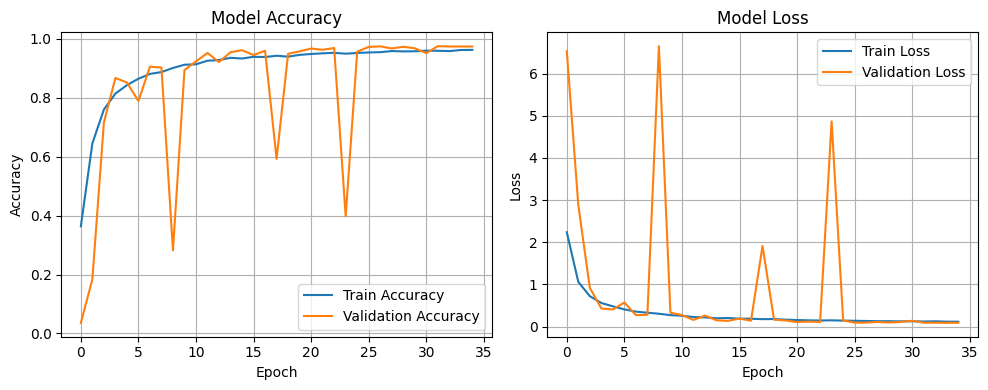

In [8]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

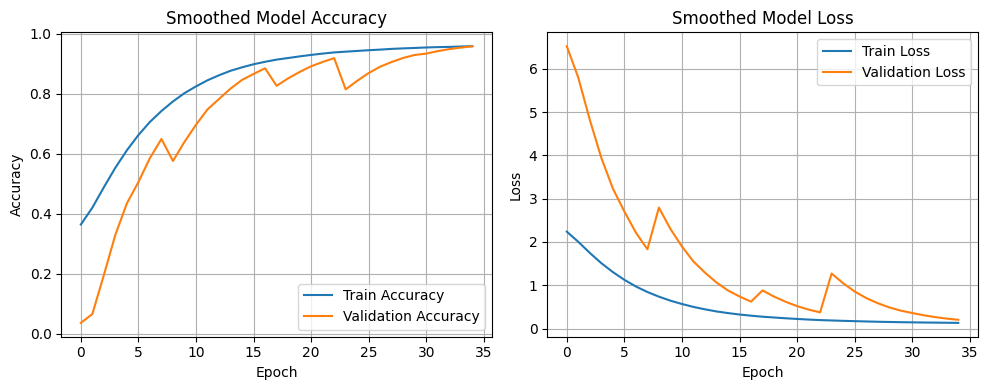

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

# Smooth accuracy and loss
smooth_train_acc = smooth_curve(history.history['accuracy'])
smooth_val_acc = smooth_curve(history.history['val_accuracy'])
smooth_train_loss = smooth_curve(history.history['loss'])
smooth_val_loss = smooth_curve(history.history['val_loss'])

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(smooth_train_acc, label='Train Accuracy')
plt.plot(smooth_val_acc, label='Validation Accuracy')
plt.title('Smoothed Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(smooth_train_loss, label='Train Loss')
plt.plot(smooth_val_loss, label='Validation Loss')
plt.title('Smoothed Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


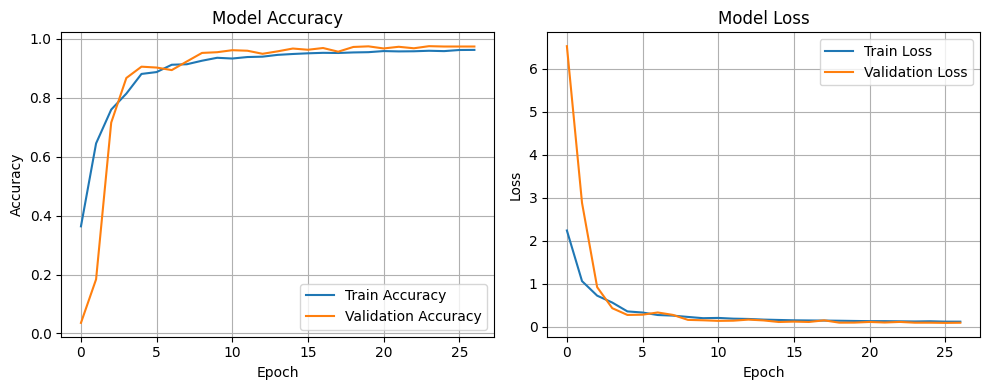

In [16]:
import matplotlib.pyplot as plt

# Extract history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Filter indices where val_accuracy doesn't randomly drop
filtered_indices = [0]  # Always keep the first point
for i in range(1, len(val_acc)):
    if val_acc[i] >= val_acc[i - 1] or abs(val_acc[i] - val_acc[i - 1]) < 0.01:  # adjust threshold
        filtered_indices.append(i)

# Filtered values
filtered_train_acc = [train_acc[i] for i in filtered_indices]
filtered_val_acc = [val_acc[i] for i in filtered_indices]
filtered_train_loss = [train_loss[i] for i in filtered_indices]
filtered_val_loss = [val_loss[i] for i in filtered_indices]
filtered_epochs = list(range(len(filtered_indices)))

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(filtered_epochs, filtered_train_acc, label='Train Accuracy')
plt.plot(filtered_epochs, filtered_val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(filtered_epochs, filtered_train_loss, label='Train Loss')
plt.plot(filtered_epochs, filtered_val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


<Figure size 10000x10000 with 0 Axes>

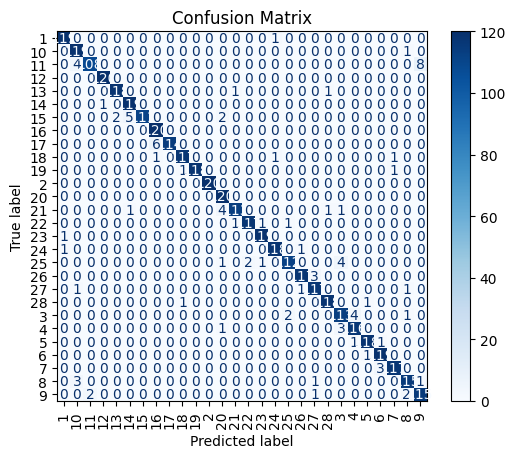

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
plt.figure(figsize=(12, 12))
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


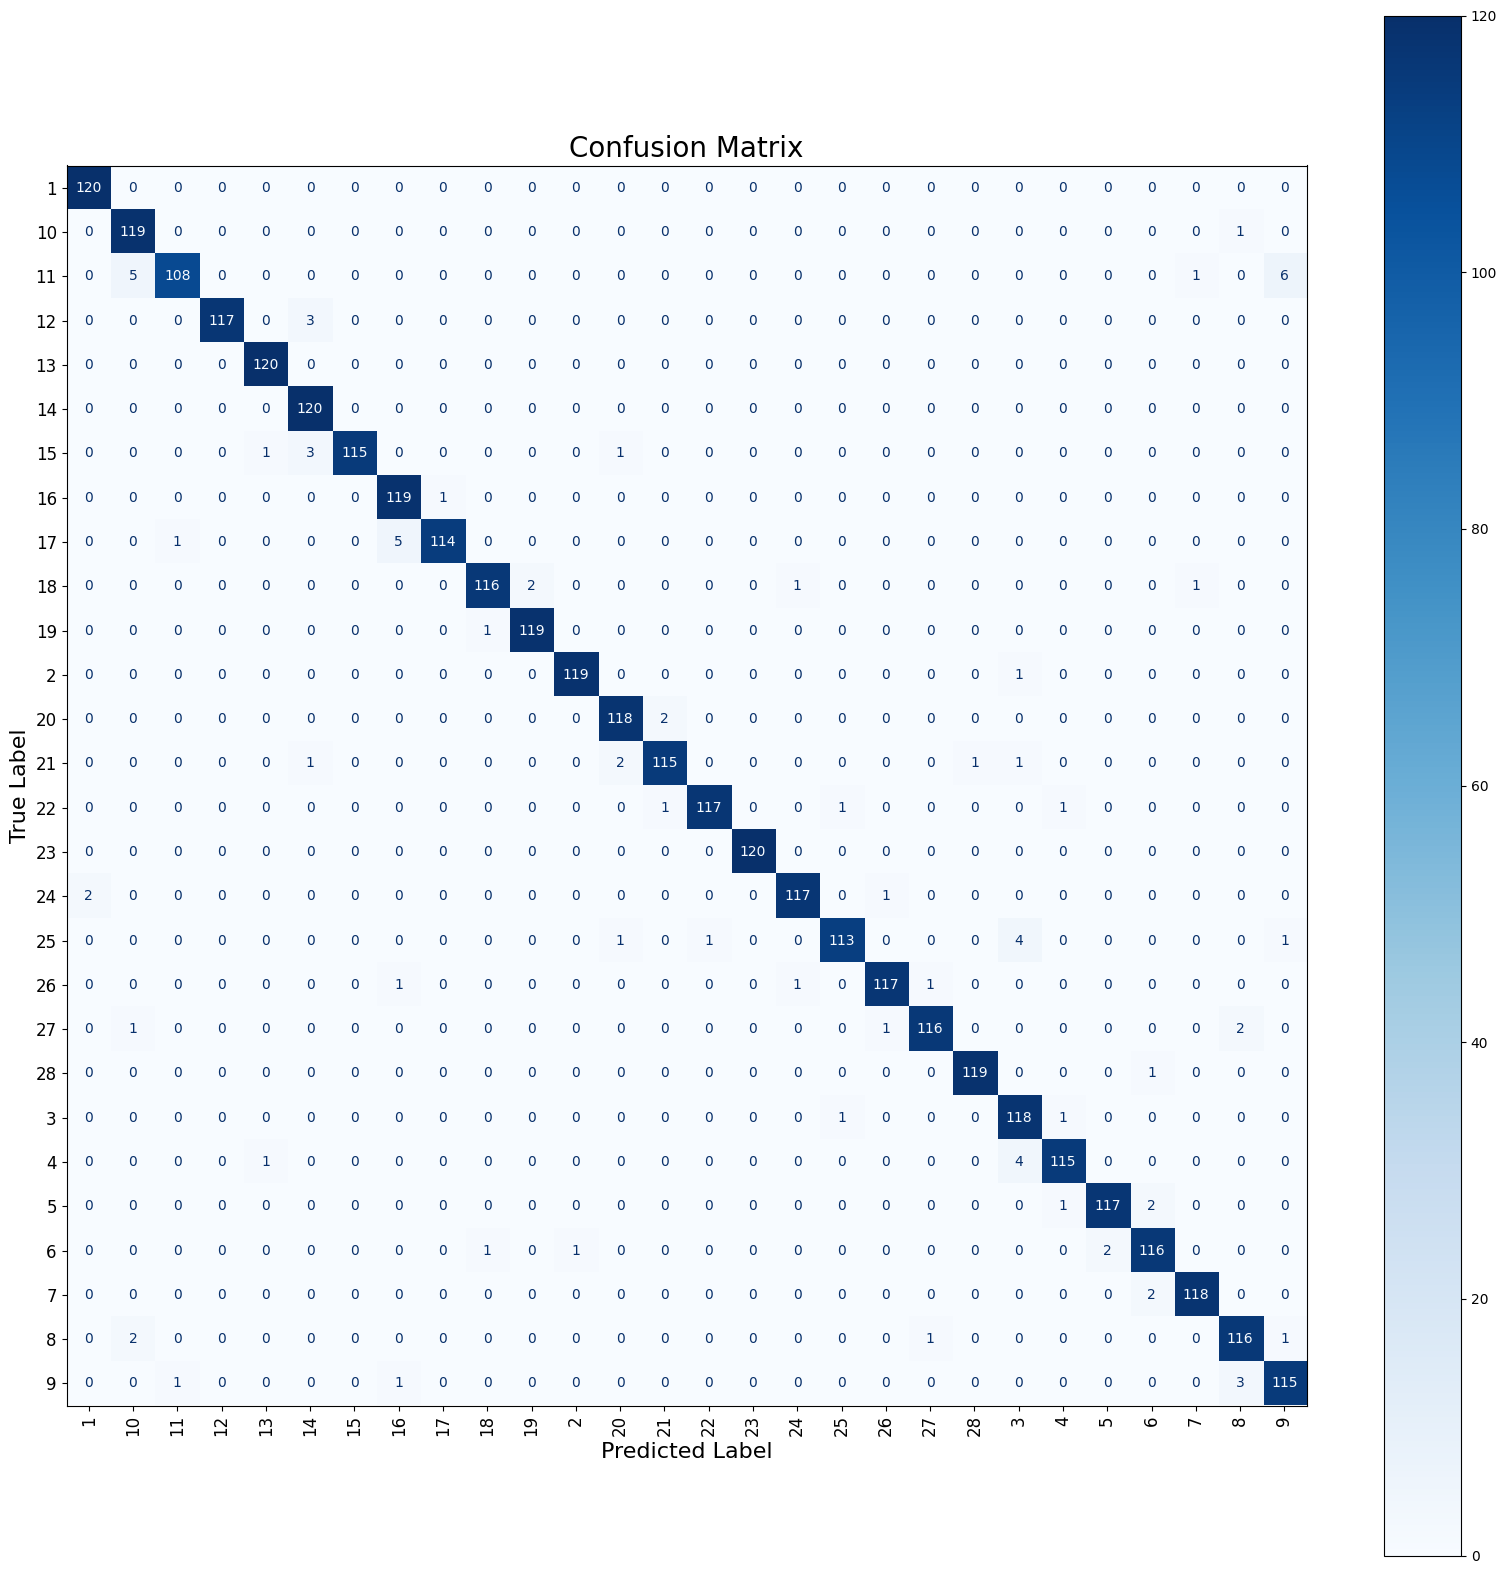

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(val_generator.class_indices.keys())

# Create large figure
fig, ax = plt.subplots(figsize=(20, 20))  # Adjust size as needed

# Display Confusion Matrix with custom axis
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)

# Improve font sizes for visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.grid(False)

plt.show()


In [15]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
📋 Classification Report:

              precision    recall  f1-score   support

           1     0.9836    1.0000    0.9917       120
          10     0.9444    0.9917    0.9675       120
          11     0.9649    0.9167    0.9402       120
          12     0.9832    0.9750    0.9791       120
          13     0.9836    1.0000    0.9917       120
          14     0.9440    0.9833    0.9633       120
          15     1.0000    0.9500    0.9744       120
          16     0.9597    0.9917    0.9754       120
          17     0.9914    0.9583    0.9746       120
          18     0.9832    0.9750    0.9791       120
          19     1.0000    0.9833    0.9916       120
           2     0.9917    0.9917    0.9917       120
          20     0.9512    0.9750    0.9630       120
          21     0.9664    0.9583    0.9623       120
          22     0.9835    0.9917    0.9876       120
          23     0.9917    0.9917    0.9917       120
          24   